In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/DS/'
midi_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/midi/'
results_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import os
import sys
import random
sys.path.append(midi_path)

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [ ]:
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# DataLoader

In [ ]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1 #utilizado para binalizar (entre 0 y 1).
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length)) #88 porque son el número de tonos
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
      #lee todo los midi files y encuentra el que tiene max lenght
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
        #hacemos que todos tengan la misma lenght, ya que si no no podriamos trabajar con ello y hacer el batch correctamente 
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [ ]:
trainset = NotesGenerationDataset(data_path + 'MuseData/train/', longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True)

In [ ]:
X = next(iter(trainset_loader))
X[0].shape

torch.Size([8, 2434, 88])

In [ ]:
valset = NotesGenerationDataset(data_path + 'MuseData/valid/', longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=8, shuffle=False, drop_last=False)

In [ ]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([8, 2523, 88])

# RNN

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [ ]:
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss().cuda()

In [ ]:
#Validamos nuestro modelo RNN que acabamos de generar
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [ ]:
validate(model)

3.1514663896858864e-06

In [ ]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [ ]:
#La intención de esta función es crear una lista de diferentes learning rates y con ellos hacer una lista con los diferentes loss que se van generando en cada época. 
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)

            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0
Epoch 1


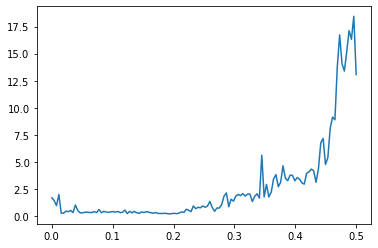

In [ ]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader, 2)

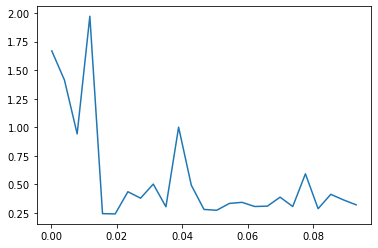

In [ ]:
plt.plot(lrs[:25], losses[:25])

[0.01       0.01113636 0.01227273 0.01340909 0.01454545 0.01568182
 0.01681818 0.01795455 0.01909091 0.02022727 0.02136364 0.0225
 0.02363636 0.02477273 0.02590909 0.02704545 0.02818182 0.02931818
 0.03045455 0.03159091 0.03272727 0.03386364 0.035      0.03409091
 0.03318182 0.03227273 0.03136364 0.03045455 0.02954545 0.02863636
 0.02772727 0.02681818 0.02590909 0.025      0.02409091 0.02318182
 0.02227273 0.02136364 0.02045455 0.01954545 0.01863636 0.01772727
 0.01681818 0.01590909 0.015      0.015      0.01473684 0.01447368
 0.01421053 0.01394737 0.01368421 0.01342105 0.01315789 0.01289474
 0.01263158 0.01236842 0.01210526 0.01184211 0.01157895 0.01131579
 0.01105263 0.01078947 0.01052632 0.01026316 0.01      ]


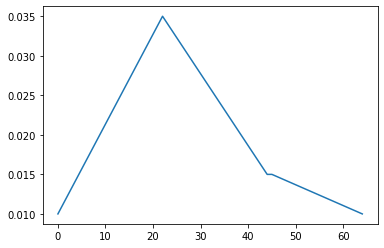

In [ ]:
#Esta función se encarga de hacer una lista de los mejores learning rates. Se llama triangular porque los coloca de forma que empiece por el más pequeño, 
#llegue gradualmente al más grande y vuelva hacia el más pequeño (o segundo más pequeño)

def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
print(lrs_triangular)
plt.plot(lrs_triangular)

In [ ]:
clip = 1.0

In [ ]:
#la función recibe por parámetro la lista lrs_triangular generada en la función descrita anteriormente.
#gracias a un condicional, la función se quedará solo con el learning rate que haga que la loss sea lo más pequeña posible.
def train_model(model, lrs_triangular, epochs_number=2, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss: #solo nos quedamos con la loss más pequeña

            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [ ]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, 10)

Training Loss: Epoch: 0 : 0.3324023343049563
Validation Loss: Epoch: 0 : 4.981898239624934e-07

Training Loss: Epoch: 1 : 0.1610457956790924
Validation Loss: Epoch: 1 : 3.8900918398728113e-07

Training Loss: Epoch: 2 : 0.15280127685803632
Validation Loss: Epoch: 2 : 3.7857313217451464e-07

Training Loss: Epoch: 3 : 0.14474232976253215
Validation Loss: Epoch: 3 : 3.878514547553696e-07

Training Loss: Epoch: 4 : 0.14633741974830627
Validation Loss: Epoch: 4 : 3.82007546956992e-07

Training Loss: Epoch: 5 : 0.145446821474112
Validation Loss: Epoch: 5 : 3.827133529917753e-07

Training Loss: Epoch: 6 : 0.14460602540236253
Validation Loss: Epoch: 6 : 3.8960109054828123e-07

Training Loss: Epoch: 7 : 0.14506967617915226
Validation Loss: Epoch: 7 : 3.9425196830617363e-07

Training Loss: Epoch: 8 : 0.14338069340357415
Validation Loss: Epoch: 8 : 3.7967159100614656e-07

Training Loss: Epoch: 9 : 0.1439729570196225
Validation Loss: Epoch: 9 : 3.732127359669925e-07



In [ ]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-4, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.14441098524973942
Validation Loss: Epoch: 0 : 3.5281407353558385e-07

Training Loss: Epoch: 1 : 0.14522986228649432
Validation Loss: Epoch: 1 : 3.532293995424084e-07

Training Loss: Epoch: 2 : 0.14286270038439677
Validation Loss: Epoch: 2 : 3.5419284177940695e-07

Training Loss: Epoch: 3 : 0.13923024030832143
Validation Loss: Epoch: 3 : 3.500820896693706e-07

Training Loss: Epoch: 4 : 0.1380459671983352
Validation Loss: Epoch: 4 : 3.4703668531445866e-07

Training Loss: Epoch: 5 : 0.13729102336443388
Validation Loss: Epoch: 5 : 3.3835830513713184e-07

Training Loss: Epoch: 6 : 0.1375874366897803
Validation Loss: Epoch: 6 : 3.3776604619306797e-07

Training Loss: Epoch: 7 : 0.13859371955578142
Validation Loss: Epoch: 7 : 3.3844308720913046e-07

Training Loss: Epoch: 8 : 0.13816129840337313
Validation Loss: Epoch: 8 : 3.3818810411732205e-07

Training Loss: Epoch: 9 : 0.13659951916107765
Validation Loss: Epoch: 9 : 3.356283310397686e-07



In [ ]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-4*5, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.14087916761636735
Validation Loss: Epoch: 0 : 3.5458731252802503e-07

Training Loss: Epoch: 1 : 0.14272970797923895
Validation Loss: Epoch: 1 : 3.51970946945952e-07

Training Loss: Epoch: 2 : 0.1412140592932701
Validation Loss: Epoch: 2 : 3.479337534534514e-07

Training Loss: Epoch: 3 : 0.14113815942635902
Validation Loss: Epoch: 3 : 3.4562794834585284e-07

Training Loss: Epoch: 4 : 0.14227365530454195
Validation Loss: Epoch: 4 : 3.4630743556850495e-07

Training Loss: Epoch: 5 : 0.14030914237866035
Validation Loss: Epoch: 5 : 3.4242083572625566e-07

Training Loss: Epoch: 6 : 0.14140752978049792
Validation Loss: Epoch: 6 : 3.4120284144706795e-07

Training Loss: Epoch: 7 : 0.1394162261715302
Validation Loss: Epoch: 7 : 3.4262542911756635e-07

Training Loss: Epoch: 8 : 0.1409437243755047
Validation Loss: Epoch: 8 : 3.4437589899149136e-07

Training Loss: Epoch: 9 : 0.13874358878685877
Validation Loss: Epoch: 9 : 3.427453503545314e-07



In [ ]:
rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth'))

<All keys matched successfully>

# Validation and sample

In [ ]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [ ]:
testset = NotesGenerationDataset(data_path + 'MuseData/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

torch.Size([223, 1, 88])

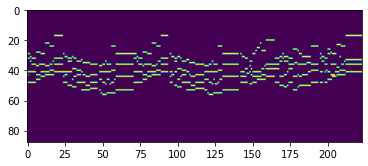

In [ ]:
plt.imshow(input_sequences_batch_var.reshape((input_sequences_batch_var.shape[0],88)).transpose(0,1).cpu()) #esto muestra una imagen del test set, así podremos comparar después.

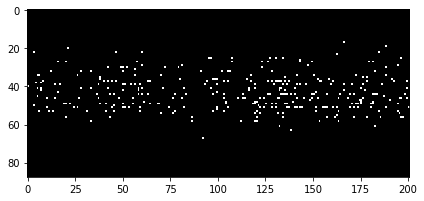

In [ ]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
io.imshow(sample) #imagen generada por nuestro programa
midiwrite(results_path + 'muse02.mid', sample.transpose(), dt=0.3) #se guarda en la carpeta results con el nombre mencionado.